# Age Detection

## Setup

### Import Statements

In [393]:
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [394]:
tf.__version__

'2.15.0'

### Notebook Presentation

In [395]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [396]:
df = pd.read_csv("./dataset/age_gender.csv")

In [397]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels
15567,4,0,1,20170109193124855.jpg.chip.jpg,42 43 57 64 71 79 84 93 99 102 108 111 116 117...
9892,28,0,1,20170109003515954.jpg.chip.jpg,43 38 20 23 20 25 54 96 156 183 198 202 201 20...
5129,24,1,0,20170117134924378.jpg.chip.jpg,69 73 71 62 68 77 71 77 85 81 77 89 94 97 105 ...
20339,59,0,1,20170104185826390.jpg.chip.jpg,54 54 57 56 55 50 47 51 49 52 56 64 65 58 52 6...
16191,41,0,1,20170117133203334.jpg.chip.jpg,176 242 230 209 168 124 118 104 127 121 133 13...


### Analyzing the Data

In [398]:
df.shape

(23705, 5)

In [399]:
df.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [400]:
df.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [401]:
df.describe()

,age,ethnicity,gender
count,"23,705.00","23,705.00","23,705.00"
mean,33.30,1.27,0.48
std,19.89,1.35,0.50
min,1.00,0.00,0.00
25%,23.00,0.00,0.00
50%,29.00,1.00,0.00
75%,45.00,2.00,1.00
max,116.00,4.00,1.00


In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


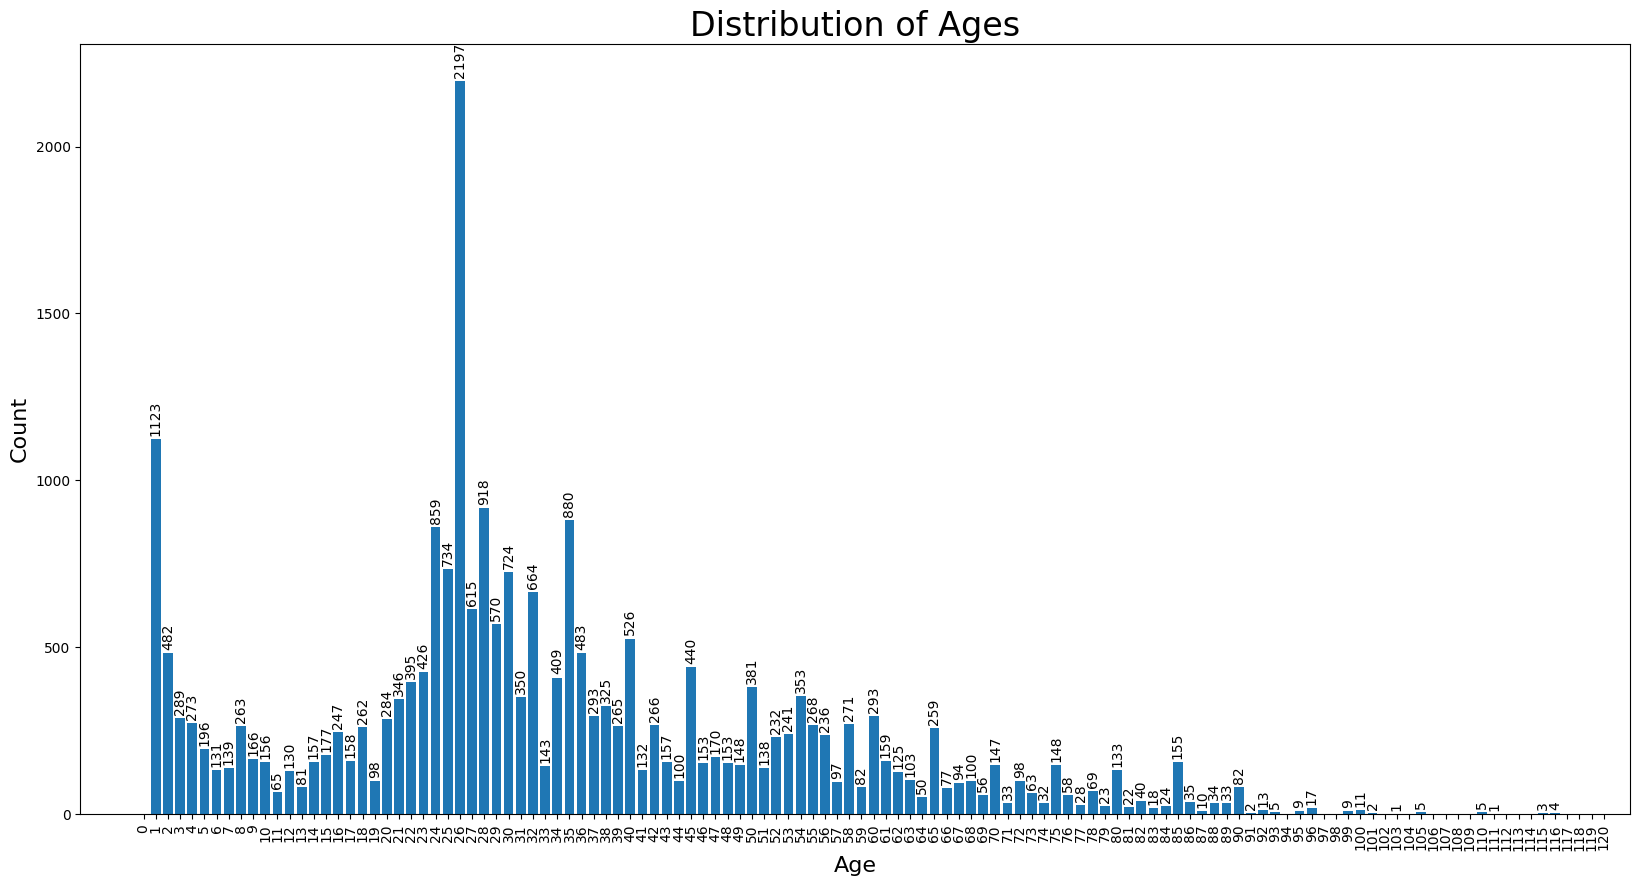

In [403]:
age_distribution = df['age'].value_counts()

plt.figure(figsize=(20, 10))
plt.bar(age_distribution.index, age_distribution.values)
plt.title("Distribution of Ages", fontsize=24)

for i, count in enumerate(age_distribution.values):
    plt.text(age_distribution.index[i], count + 10, str(count), ha='center', va='bottom', rotation=90)

plt.xticks(range(0, 121), rotation=90)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

### Additional Changes to the Data

#### Discretization of the Ages

In [404]:
age_bins = [0, 17, 25, 35, 45, 55, 64, 120]
age_labels = [0, 1, 2, 3, 4, 5, 6]

df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

In [405]:
df.sample(5)

,age,ethnicity,gender,img_name,pixels
22138,6,0,0,20170111201853033.jpg.chip.jpg,151 156 164 216 239 232 217 207 187 189 186 19...
9986,2,1,0,20170113133331563.jpg.chip.jpg,96 49 30 28 25 26 23 40 77 102 108 113 108 106...
16863,4,1,1,20170116233320931.jpg.chip.jpg,46 44 58 79 100 111 117 126 135 139 142 139 13...
8895,2,1,0,20170117164420634.jpg.chip.jpg,221 122 34 26 38 51 54 48 60 62 55 54 56 61 66...
16919,4,0,0,20170119171850161.jpg.chip.jpg,92 105 94 85 78 87 104 111 111 111 111 111 110...


In [406]:
df['age'].unique()

[0, 6, 1, 2, 3, 4, 5]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]

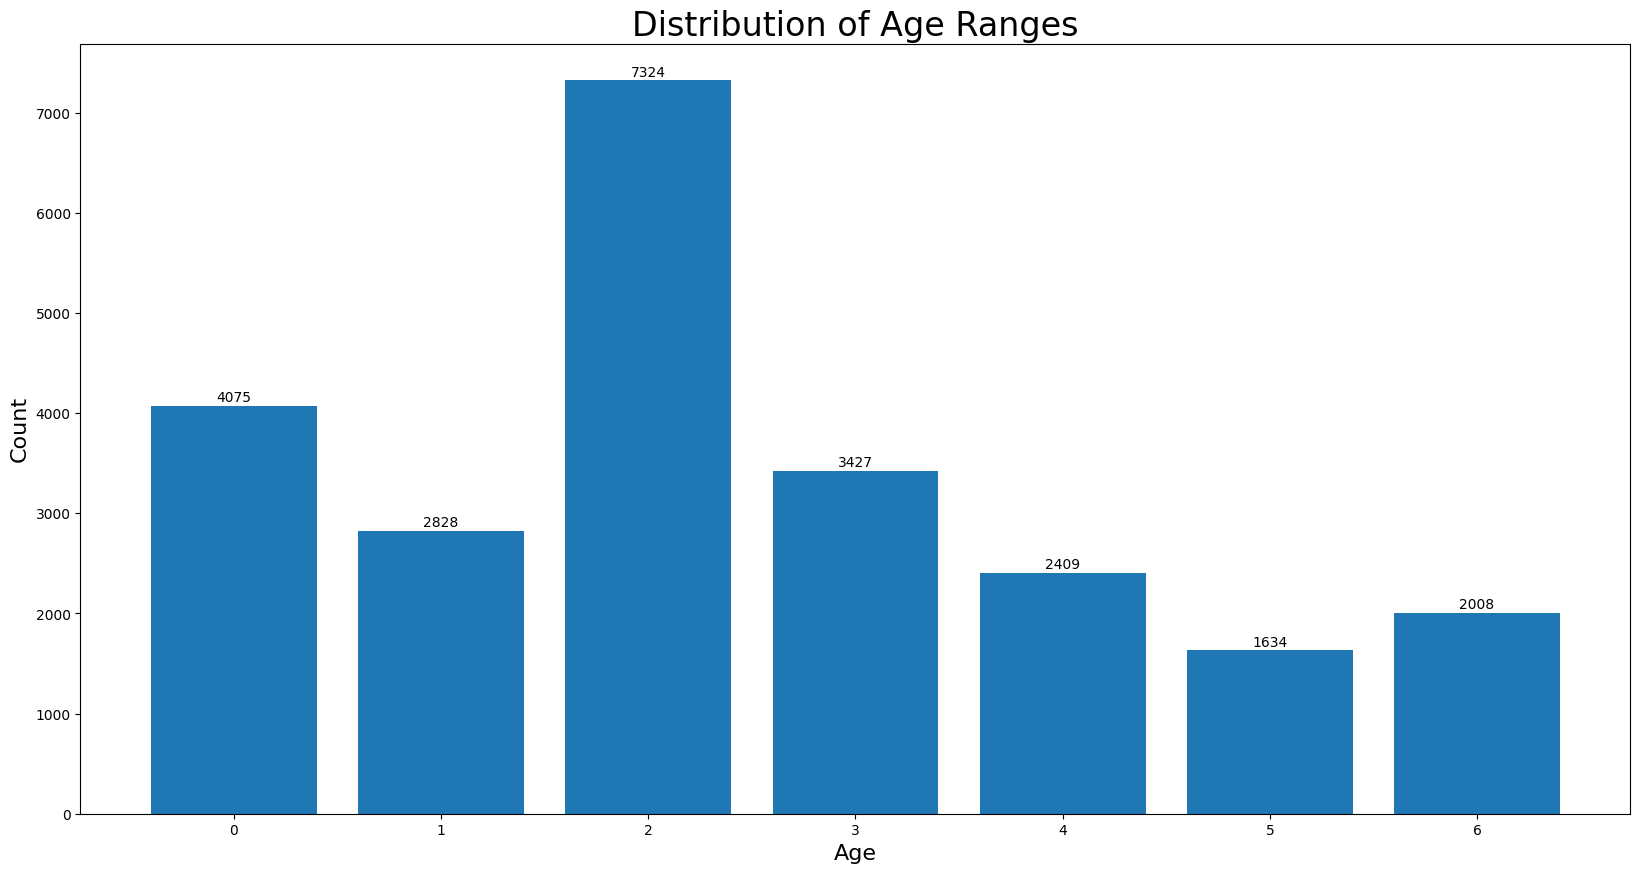

In [407]:
age_range_distribution = df['age'].value_counts().sort_index()

plt.figure(figsize=(20, 10))
plt.bar(age_range_distribution.index, age_range_distribution.values)
plt.title("Distribution of Age Ranges", fontsize=24)

for i, count in enumerate(age_range_distribution.values):
    plt.text(age_range_distribution.index[i], count + 10, str(count), ha='center', va='bottom')

plt.xticks(age_range_distribution.index)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()

#### Reshaping the Pixels

In [408]:
df['pixels'] = df['pixels'].apply(lambda x:  np.array(x.split(), dtype='float32'))

df['pixels'][0]

array([129., 128., 128., ..., 146., 146., 146.], dtype=float32)

In [409]:
X = np.array(df['pixels'].tolist())

X.shape

(23705, 2304)

In [410]:
X = X.reshape(-1, 48, 48, 1)

X[0].shape

(48, 48, 1)

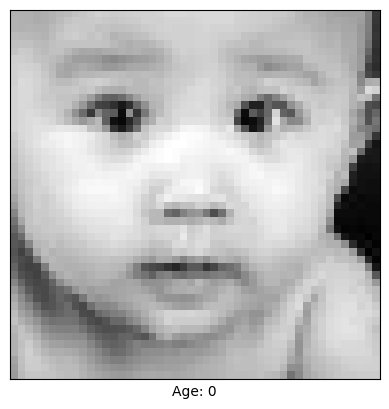

In [411]:
plt.imshow(X[0], cmap='gray')
plt.xlabel(f"Age: {df['age'][0]}")

plt.xticks([])
plt.yticks([])
plt.grid(False)

## Data Preprocessing

### Training and Test Split

In [412]:
X = X / 255.0 # Normalizing the inputs
y= tf.keras.utils.to_categorical(np.array(df['age']),num_classes=7)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

### Building the CNN

In [413]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

cnn.add(tf.keras.layers.Dense(units=7, activation='softmax'))

## Compiling the CNN

In [414]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [415]:
cnn.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=30)

Epoch 1/30


593/593 [==============================] - 9s 13ms/step - loss: 1.4700 - accuracy: 0.4447 - val_loss: 1.2738 - val_accuracy: 0.4908
Epoch 2/30
593/593 [==============================] - 7s 12ms/step - loss: 1.2515 - accuracy: 0.5064 - val_loss: 1.2093 - val_accuracy: 0.5193
Epoch 3/30
593/593 [==============================] - 7s 12ms/step - loss: 1.1763 - accuracy: 0.5252 - val_loss: 1.1372 - val_accuracy: 0.5317
Epoch 4/30
593/593 [==============================] - 7s 12ms/step - loss: 1.1280 - accuracy: 0.5466 - val_loss: 1.1226 - val_accuracy: 0.5391
Epoch 5/30
593/593 [==============================] - 7s 12ms/step - loss: 1.0882 - accuracy: 0.5548 - val_loss: 1.0952 - val_accuracy: 0.5486
Epoch 6/30
593/593 [==============================] - 7s 12ms/step - loss: 1.0559 - accuracy: 0.5666 - val_loss: 1.0959 - val_accuracy: 0.5417
Epoch 7/30
593/593 [==============================] - 7s 12ms/step - loss: 1.0245 - accuracy: 0.5745 - val_loss: 1.0746 - val_accuracy: 0.55